In [1]:
using DrWatson
@quickactivate("Hierarchical_Infer_Spikes")

using HiddenMarkovModels, CSV, StatsPlots, DataFrames, Distributions, Random, LinearAlgebra

# load data
data = CSV.read(datadir("exp_pro","viterbi_states_KA.csv"), DataFrame)

Row,Animal,Day,Outcome,Side,SpikeCount,Times,ViterbiGuess
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7.0,1.0,1.0,0.0,1.0,31.9488,2.0
2,7.0,1.0,1.0,1.0,2.0,32.1877,3.0
3,7.0,1.0,0.0,1.0,4.0,33.2231,3.0
4,7.0,1.0,1.0,0.0,10.0,35.0549,3.0
5,7.0,1.0,1.0,1.0,3.0,31.6814,3.0
6,7.0,1.0,0.0,1.0,6.0,34.4576,3.0
7,7.0,1.0,0.0,1.0,5.0,34.2016,3.0
8,7.0,1.0,1.0,0.0,2.0,36.5141,3.0
9,7.0,1.0,0.0,0.0,1.0,31.3549,3.0


In [127]:
using StatsBase
function hierarchical_bootstrap_state(data,N_boot=1000)
    state_means = zeros(N_boot,3)

    for state in 1:3
        state_data = data[data[!,Symbol("ViterbiGuess")] .== state,:]
        for i in 1:N_boot
            # sample animals with replacement
            animals_in_state = unique(state_data[!,:Animal])
            # count number of trials in given animal
            num_trials = StatsBase.FrequencyWeights([sum(state_data[!,:Animal] .== animal) for animal in animals_in_state])

            animals = sample(animals_in_state,num_trials,length(state_data[:,1]);replace=true) # sample with replacement the same number of observation in given state
            # for each animal and day (assumed indepdent), sample a spike rate
            spike_rates = []
            for animal in animals
                animal_data = state_data[state_data[!,:Animal] .== animal,:]
                rates = animal_data[!,:SpikeCount]#./animal_data[!,:Times]
                rate = sample(rates,1)[1]
                push!(spike_rates,rate)
            end
            state_means[i,state] = mean(spike_rates)
        end
    end
    return state_means
end

function hierarchical_bootstrap_states_TIMES(data,N_boot=1000)
    state_means = zeros(N_boot,3)

    for state in 1:3
        state_data = data[data[!,Symbol("ViterbiGuess")] .== state,:]
        for i in 1:N_boot
            # sample animals with replacement
            animals_in_state = unique(state_data[!,:Animal])
            # count number of trials in given animal
            num_trials = StatsBase.FrequencyWeights([sum(state_data[!,:Animal] .== animal) for animal in animals_in_state])

            animals = sample(animals_in_state,num_trials,length(state_data[:,1]);replace=true) # sample with replacement the same number of observation in given state
            # for each animal and day (assumed indepdent), sample a spike rate
            delay_time = []
            for animal in animals
                animal_data = state_data[state_data[!,:Animal] .== animal,:]
                times = animal_data[!,:Times]
                time = sample(times,1)[1]
                push!(delay_time,time)
            end
            state_means[i,state] = mean(delay_time)
        end
    end
    return state_means
end

state_means = hierarchical_bootstrap_state(data,1000)
state_means_TIMES = hierarchical_bootstrap_states_TIMES(data,1000)

1000×3 Matrix{Float64}:
 41.7907  38.3153  37.714
 42.995   37.7286  38.2663
 41.5959  38.5975  37.1838
 41.0075  38.6354  37.7629
 43.0558  38.2244  37.6694
 45.8664  37.3412  36.9527
 39.3114  37.5596  37.796
 39.5256  37.47    37.3754
 40.7507  37.6298  37.2018
 38.577   37.6042  37.5288
  ⋮                
 41.3766  38.1997  37.9992
 46.433   38.4357  37.4589
 42.2951  37.6426  36.7496
 40.2856  36.9088  37.6925
 42.5419  37.0074  38.4553
 42.8119  37.853   38.3395
 42.994   37.9389  36.7465
 41.4476  37.4718  37.482
 41.9868  37.9718  37.886

## A predictive check of the HMM

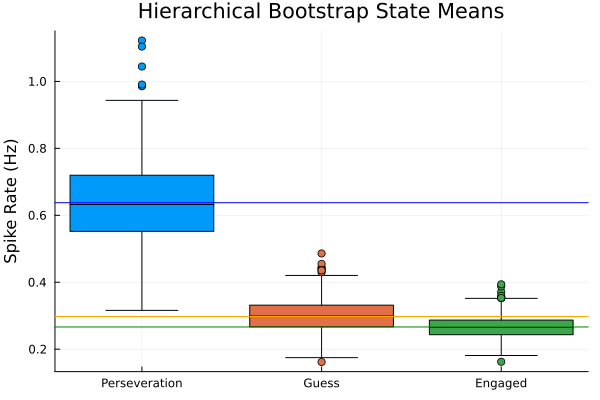

In [123]:
@df DataFrame(state_means, [:State1, :State2, :State3]) boxplot([:State1, :State2, :State3], legend=false, title="Hierarchical Bootstrap State Means", ylabel="Spike Rate (Hz)")
hline!([mean(data[data[!,:ViterbiGuess] .== 1,:SpikeCount]./data[data[!,:ViterbiGuess] .== 1,:Times])],label="True State 1 Mean",color="blue")
hline!([mean(data[data[!,:ViterbiGuess] .== 2,:SpikeCount]./data[data[!,:ViterbiGuess] .== 2,:Times])],label="True State 2 Mean",color="orange")
hline!([mean(data[data[!,:ViterbiGuess] .== 3,:SpikeCount]./data[data[!,:ViterbiGuess] .== 3,:Times])],label="True State 3 Mean",color="green")
xticks!([1,2,3],["Perseveration","Guess","Engaged"])

## Reproduces Table 7

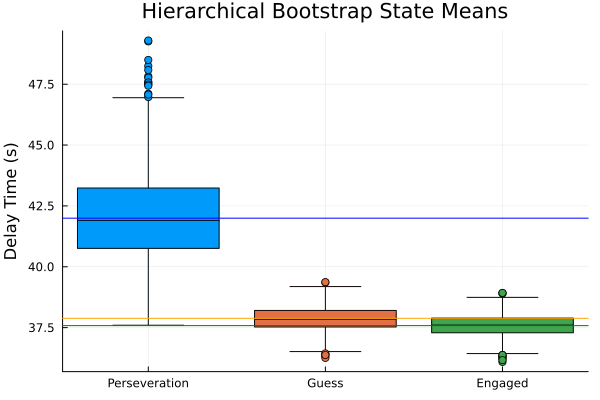

In [124]:
# plot the delay times
@df DataFrame(state_means_TIMES, [:State1, :State2, :State3]) boxplot([:State1, :State2, :State3], legend=false, title="Hierarchical Bootstrap State Means", ylabel="Delay Time (s)")
hline!([mean(data[data[!,:ViterbiGuess] .== 1,:Times])],label="True State 1 Mean",color="blue")
hline!([mean(data[data[!,:ViterbiGuess] .== 2,:Times])],label="True State 2 Mean",color="orange")
hline!([mean(data[data[!,:ViterbiGuess] .== 3,:Times])],label="True State 3 Mean",color="green")
xticks!([1,2,3],["Perseveration","Guess","Engaged"])

In [114]:
using HypothesisTests
OneWayANOVATest(state_means[:,1],state_means[:,2],state_means[:,3])

One-way analysis of variance (ANOVA) test
-----------------------------------------
Population details:
    parameter of interest:   Means
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    number of observations: [1000, 1000, 1000]
    F statistic:            4501.0
    degrees of freedom:     (2, 2997)


In [115]:
# post-hoc tests
for i in 1:3
    for j in i+1:3
        println("State $i vs State $j")
        p = pvalue(UnequalVarianceTTest(state_means[:,i],state_means[:,j]))
        println("p = $p")
    end
end

State 1 vs State 2
p = 0.0
State 1 vs State 3
p = 0.0
State 2 vs State 3
p = 1.842556526387482e-39


In [128]:
# confidence intervals
for i in 1:3
    println("State $i")
    println(confint(OneSampleTTest(state_means[:,i])))
end

State 1
(25.212763936746356, 25.76451731325364)
State 2
(11.24718930933082, 11.473604341462833)
State 3
(10.222651679792312, 10.383297364793675)


In [125]:
# delay time confidence intervals
for i in 1:3
    println("State $i")
    println(confint(OneSampleTTest(state_means_TIMES[:,i])))
end

State 1
(41.92982281340182, 42.16184465203566)
State 2
(37.840557620050845, 37.90248301142532)
State 3
(37.55664840518975, 37.61336177698284)
